# HP Jupyter Environment Demo: Reinsurance Portfolio Analysis

This notebook demonstrates HP's Jupyter capabilities through a comprehensive reinsurance portfolio analysis. It includes synthetic data generation, statistical analysis, and interactive visualizations to help insurance professionals understand their portfolio distribution and risk exposure.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Set default figure size for all plots
plt.rcParams['figure.figsize'] = [12, 6]

## Data Generation Functions

These functions create synthetic insurance policy data with industry-specific risk parameters and policy limits.

In [2]:
def generate_risk_score(industry):
    # Industry-specific risk score parameters
    industry_risk_params = {
        'Manufacturing': (70, 15),  # Higher risk due to equipment and safety
        'Healthcare': (60, 12),     # Moderate risk with strict regulations
        'Technology': (55, 10),     # Lower risk with mainly office-based operations
        'Retail': (65, 13),         # Moderate risk with public exposure
        'Energy': (75, 18)          # Highest risk due to operational hazards
    }
    mean, std = industry_risk_params[industry]
    return float(np.clip(np.random.normal(mean, std), 0, 100))

def generate_policy_limit(industry, risk_score):
    # Base distribution parameters influenced by industry
    industry_limit_factors = {
        'Manufacturing': 2.0,  # Higher limits due to equipment value
        'Healthcare': 1.8,     # High limits due to liability
        'Technology': 1.5,     # Moderate limits
        'Retail': 1.2,        # Lower limits
        'Energy': 2.5         # Highest limits due to infrastructure
    }
    
    # Risk score influence on limit (higher risk → tendency for higher limits)
    risk_factor = 1 + (risk_score - 50) / 100
    
    # Generate base limit with industry factor and risk adjustment
    base_limit = float(np.random.lognormal(
        mean=np.log(5_000_000),  # Center around 5M
        sigma=1.2  # Wide spread
    )) * industry_limit_factors[industry] * risk_factor
    
    # Add some randomness while maintaining the relationship
    final_limit = base_limit + np.random.normal(0, base_limit * 0.1)
    return max(100_000, final_limit)

def generate_reinsurance_data(n_policies=1000):
    # Industry distribution (weighted towards manufacturing and healthcare)
    industries = np.random.choice(
        ['Manufacturing', 'Healthcare', 'Technology', 'Retail', 'Energy'],
        size=n_policies,
        p=[0.35, 0.25, 0.2, 0.15, 0.05]  # Adjusted probabilities
    )
    
    # Generate risk scores based on industry
    risk_scores = np.array([generate_risk_score(ind) for ind in industries])
    
    # Generate policy limits based on industry and risk score
    policy_limits = np.array([
        generate_policy_limit(ind, risk) 
        for ind, risk in zip(industries, risk_scores)
    ]).round(-4)  # Round to nearest 10k
    
    # Create DataFrame
    df = pd.DataFrame({
        'policy_id': range(1, n_policies + 1),
        'industry': industries,
        'risk_score': risk_scores,
        'policy_limit': policy_limits
    })
    
    return df

## Reinsurance Band Classification

This function categorizes policies into five standard reinsurance bands based on their policy limits.

In [3]:
def create_reinsurance_bands(df):
    bands = [
        (0, 1_000_000, 'Band 1: Up to $1M'),
        (1_000_000, 5_000_000, 'Band 2: $1M - $5M'),
        (5_000_000, 10_000_000, 'Band 3: $5M - $10M'),
        (10_000_000, 50_000_000, 'Band 4: $10M - $50M'),
        (50_000_000, float('inf'), 'Band 5: $50M+')
    ]
    
    def get_band(limit):
        for low, high, label in bands:
            if low <= limit < high:
                return label
        return bands[-1][2]  # Return highest band if above all thresholds
    
    df['reinsurance_band'] = df['policy_limit'].apply(get_band)
    return df

## Portfolio Analysis Functions

These functions provide detailed analysis of the portfolio distribution and create visualizations.

In [4]:
def analyze_portfolio(df):
    # Basic statistics
    print("\n=== Portfolio Analysis ===")
    print(f"Total number of policies: {len(df):,}")
    print(f"Total portfolio value: ${df['policy_limit'].sum():,.2f}")
    print(f"Average policy limit: ${df['policy_limit'].mean():,.2f}")
    print(f"Median policy limit: ${df['policy_limit'].median():,.2f}")
    
    # Band distribution
    band_dist = df['reinsurance_band'].value_counts().sort_index()
    print("\n=== Band Distribution ===")
    for band, count in band_dist.items():
        total_value = df[df['reinsurance_band'] == band]['policy_limit'].sum()
        print(f"{band}:")
        print(f"  Policies: {count:,} ({count/len(df)*100:.1f}%)")
        print(f"  Total Value: ${total_value:,.2f}")
        print(f"  Average Limit: ${total_value/count:,.2f}")
    
    # Industry distribution within bands
    print("\n=== Industry Distribution by Band ===")
    industry_band_dist = pd.crosstab(df['reinsurance_band'], df['industry'], normalize='index') * 100
    print(industry_band_dist.round(1))
    
    # Risk analysis
    print("\n=== Risk Score Analysis ===")
    risk_stats = df.groupby('reinsurance_band')['risk_score'].agg(['mean', 'std', 'min', 'max'])
    print("\nRisk Score Statistics by Band:")
    print(risk_stats.round(2))

def create_visualizations(df):
    # Set style for better visualization
    plt.style.use('default')
    sns.set_theme(style="whitegrid")
    
    # 1. Band Distribution
    plt.figure()
    band_counts = df['reinsurance_band'].value_counts().sort_index()
    colors = sns.color_palette("husl", n_colors=len(band_counts))
    ax = band_counts.plot(kind='bar', color=colors)
    plt.title('Distribution of Policies Across Reinsurance Bands')
    plt.xlabel('Reinsurance Band')
    plt.ylabel('Number of Policies')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for i, v in enumerate(band_counts):
        ax.text(i, v, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Risk Score Distribution by Band
    plt.figure()
    sns.boxplot(data=df, x='reinsurance_band', y='risk_score')
    plt.title('Risk Score Distribution by Reinsurance Band')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 3. Industry Distribution
    plt.figure()
    industry_band = pd.crosstab(df['reinsurance_band'], df['industry'], normalize='index')
    industry_band.plot(kind='bar', stacked=True)
    plt.title('Industry Distribution Within Each Reinsurance Band')
    plt.xlabel('Reinsurance Band')
    plt.ylabel('Proportion')
    plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='center left')
    plt.tight_layout()
    plt.show()

    # 4. Risk Score vs Policy Limit
    plt.figure()
    sns.scatterplot(data=df, x='risk_score', y='policy_limit', hue='industry', alpha=0.6)
    plt.title('Risk Score vs Policy Limit by Industry')
    plt.xlabel('Risk Score')
    plt.ylabel('Policy Limit ($)')
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='center left')
    plt.tight_layout()
    plt.show()

## Generate and Analyze Portfolio Data

Now let's generate a sample portfolio and analyze its characteristics.

In [5]:
# Generate synthetic dataset
df = generate_reinsurance_data()

# Add reinsurance bands
df = create_reinsurance_bands(df)

# Display sample of the data
print("Sample of the generated dataset:")
df.head()

Sample of the generated dataset:


,policy_id,industry,risk_score,policy_limit,reinsurance_band
0,1,Healthcare,62.132412,1850000.0,Band 2: $1M - $5M
1,2,Energy,50.963802,2230000.0,Band 2: $1M - $5M
2,3,Technology,58.801979,7700000.0,Band 3: $5M - $10M
3,4,Healthcare,67.327029,6740000.0,Band 3: $5M - $10M
4,5,Manufacturing,78.396857,21360000.0,Band 4: $10M - $50M


In [6]:
# Run portfolio analysis
analyze_portfolio(df)


=== Portfolio Analysis ===
Total number of policies: 1,000
Total portfolio value: $20,546,560,000.00
Average policy limit: $20,546,560.00
Median policy limit: $9,675,000.00

=== Band Distribution ===
Band 1: Up to $1M:
  Policies: 38 (3.8%)
  Total Value: $26,410,000.00
  Average Limit: $695,000.00
Band 2: $1M - $5M:
  Policies: 265 (26.5%)
  Total Value: $783,190,000.00
  Average Limit: $2,955,433.96
Band 3: $5M - $10M:
  Policies: 206 (20.6%)
  Total Value: $1,516,410,000.00
  Average Limit: $7,361,213.59
Band 4: $10M - $50M:
  Policies: 406 (40.6%)
  Total Value: $9,176,330,000.00
  Average Limit: $22,601,798.03
Band 5: $50M+:
  Policies: 85 (8.5%)
  Total Value: $9,044,220,000.00
  Average Limit: $106,402,588.24

=== Industry Distribution by Band ===
industry             Energy  Healthcare  Manufacturing  Retail  Technology
reinsurance_band                                                          
Band 1: Up to $1M       0.0        42.1           15.8    34.2         7.9
Band 2: $

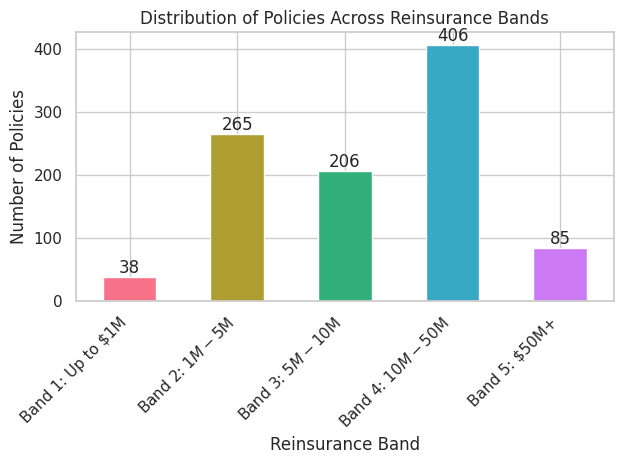

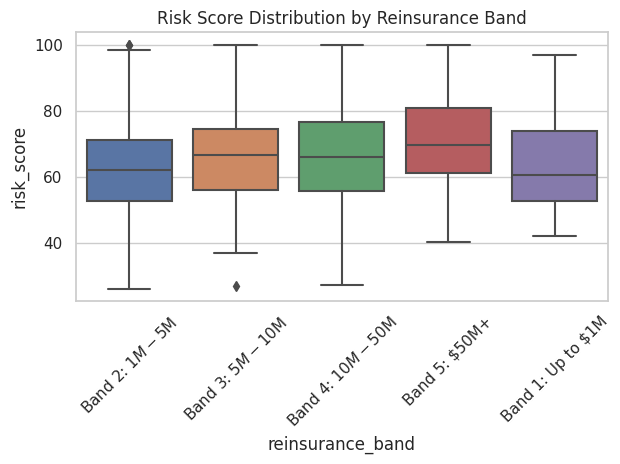

<Figure size 640x480 with 0 Axes>

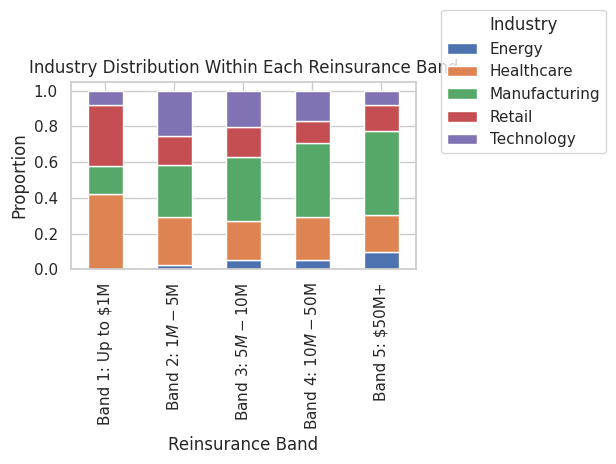

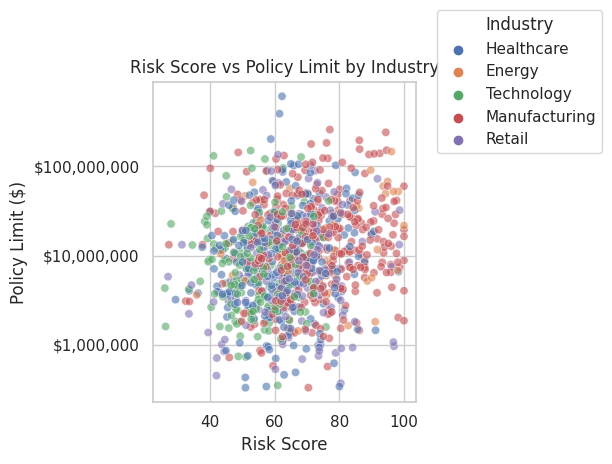

In [7]:
# Generate visualizations
create_visualizations(df)

## Key Insights

The analysis provides several key insights:

1. **Band Distribution**: Shows how policies are distributed across different limit bands, helping identify concentration risks
2. **Risk Score Analysis**: Reveals the relationship between policy limits and risk scores
3. **Industry Exposure**: Demonstrates the portfolio's industry diversification within each band

This analysis can help in:
- Optimizing reinsurance strategy
- Managing exposure concentrations
- Understanding industry-specific risks
- Identifying potential areas for growth or reduction